# K-Means 

In [ ]:
import sys
import os

sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))

from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

spark = SparkSession.builder.appName("KMeansClustering").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

## Načítanie predspracovaných dát

In [2]:
from preprocessing.preprocessing import preprocess_data

df_train_model, df_test_model = preprocess_data()

print("\nDataset schema:")
df_train_model.printSchema()

print("\nSample records:")
df_train_model.select("features", "Accident_Severity").show(5, truncate=False)


Dataset schema:
root
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Police_Force: integer (nullable = true)
 |-- Accident_Severity: integer (nullable = true)
 |-- Number_of_Vehicles: integer (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Local_Authority_(District): integer (nullable = true)
 |-- 1st_Road_Number: integer (nullable = true)
 |-- Speed_limit: integer (nullable = true)
 |-- Junction_Detail: integer (nullable = true)
 |-- Junction_Control: integer (nullable = true)
 |-- 2nd_Road_Class: integer (nullable = true)
 |-- 2nd_Road_Number: integer (nullable = true)
 |-- Urban_or_Rural_Area: integer (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: integer (nullable = true)
 |-- Vehicle_Reference: integer (nullable = true)
 |-- Casualty_Reference: integer (nullable = true)
 |-- Casualty_Severity: integer (nullable = true)
 |-- Casualty_Type: integer (nullable = true)
 |

## Hľadanie optimálneho počtu cluster-ov

Computing cost for different values of k...
k=2, WSSSE=4649915463828867.0000
k=3, WSSSE=3503903265997828.0000
k=4, WSSSE=1903518108393668.2500
k=5, WSSSE=1526985178258468.2500
k=6, WSSSE=1366868101951217.0000
k=7, WSSSE=1286174417851217.5000
k=8, WSSSE=971796163727299.1250
k=9, WSSSE=1129495171981973.2500
k=10, WSSSE=814358038123113.6250


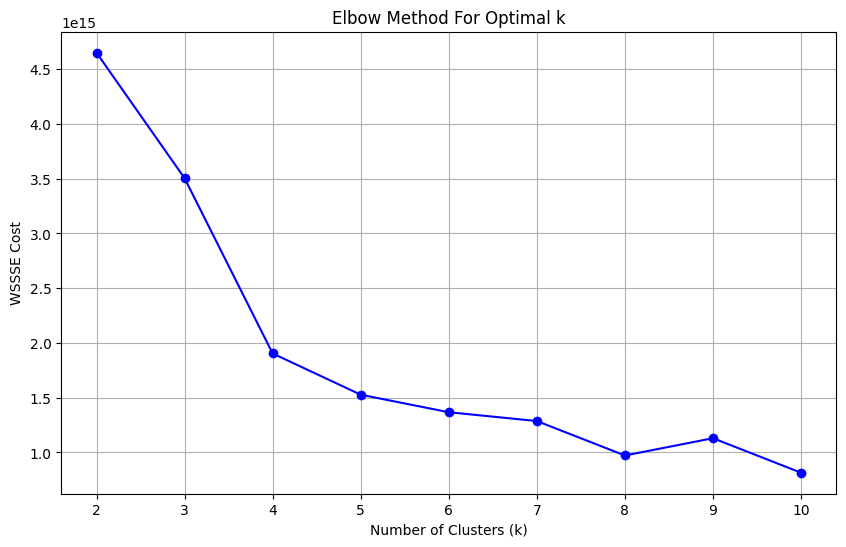

In [3]:
# Function to compute cost (WSSSE) for different k values
def compute_cost(df, k_values, features_col="features"):
    costs = []
    for k in k_values:
        kmeans = KMeans(k=k, seed=42, featuresCol=features_col)
        model = kmeans.fit(df)
        wssse = model.summary.trainingCost
        costs.append(wssse)
        print(f"k={k}, WSSSE={wssse:.4f}")
    return costs

# Define a range of k values to test
k_values = list(range(2, 11))

# Compute cost for each k
print("Computing cost for different values of k...")
costs = compute_cost(df_train_model, k_values)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, costs, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE Cost')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.xticks(k_values)
plt.show()

## Trénovanie K-means modelu s optimálnym počtom cluster-ov

In [3]:
# Set the optimal k value based on the elbow plot
optimal_k = 4

# Train K-means with the optimal k
kmeans = KMeans(k=optimal_k, seed=42, featuresCol="features")
model = kmeans.fit(df_train_model)

# Print cluster centers
centers = model.clusterCenters()
print(f"Cluster Centers for k={optimal_k}:")
for i, center in enumerate(centers):
    # Print the first few dimensions of each center for brevity
    print(f"Cluster {i}: {center[:5]}...")

# Evaluate clustering by computing Silhouette score
predictions = model.transform(df_train_model)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"\nSilhouette with squared euclidean distance = {silhouette:.4f}")

Cluster Centers for k=4:
Cluster 0: [3.24523302e+05 1.50795036e+05 5.32059141e+01 2.38642681e+00
 2.22133004e+00]...
Cluster 1: [3.39906403e+05 6.40716179e+05 6.11158409e+01 2.16012791e+00
 2.06350789e+00]...
Cluster 2: [5.29010947e+05 1.88139811e+05 2.90181341e+01 2.45595010e+00
 2.07826492e+00]...
Cluster 3: [4.09282620e+05 3.76161056e+05 1.73427108e+01 2.28867580e+00
 2.17200298e+00]...

Silhouette with squared euclidean distance = 0.7144


## Analýza cluster-ov

In [4]:
# Apply the model to the training data
clustered_data = model.transform(df_train_model)

# Examine the distribution of Accident Severity within each cluster
severity_by_cluster = clustered_data.groupBy("prediction", "Accident_Severity").count().orderBy("prediction", "Accident_Severity")
print("Distribution of Accident Severity by Cluster:")
severity_by_cluster.show()

# Create a more detailed view of the cluster characteristics
print("Cluster Summary Statistics:")
cluster_stats = clustered_data.groupBy("prediction").agg({
    "Accident_Severity": "mean",  # Average severity
    "*": "count"  # Count of records in each cluster
}).orderBy("prediction")

cluster_stats = cluster_stats.withColumnRenamed("avg(Accident_Severity)", "avg_severity")
cluster_stats = cluster_stats.withColumnRenamed("count(1)", "cluster_size")
cluster_stats.show()

Distribution of Accident Severity by Cluster:
+----------+-----------------+-----+
|prediction|Accident_Severity|count|
+----------+-----------------+-----+
|         0|                1| 1014|
|         0|                2| 5235|
|         0|                3|32607|
|         1|                1|  814|
|         1|                2| 4654|
|         1|                3|23615|
|         2|                1| 1955|
|         2|                2|16121|
|         2|                3|97838|
|         3|                1| 2200|
|         3|                2|15870|
|         3|                3|98521|
+----------+-----------------+-----+

Cluster Summary Statistics:
+----------+------------------+------------+
|prediction|      avg_severity|cluster_size|
+----------+------------------+------------+
|         0| 2.813079061148857|       38856|
|         1|2.7839975243269266|       29083|
|         2| 2.827190848387598|      115914|
|         3|2.8261443850726042|      116591|
+----------+------

## Vizualizácia cluster-ov

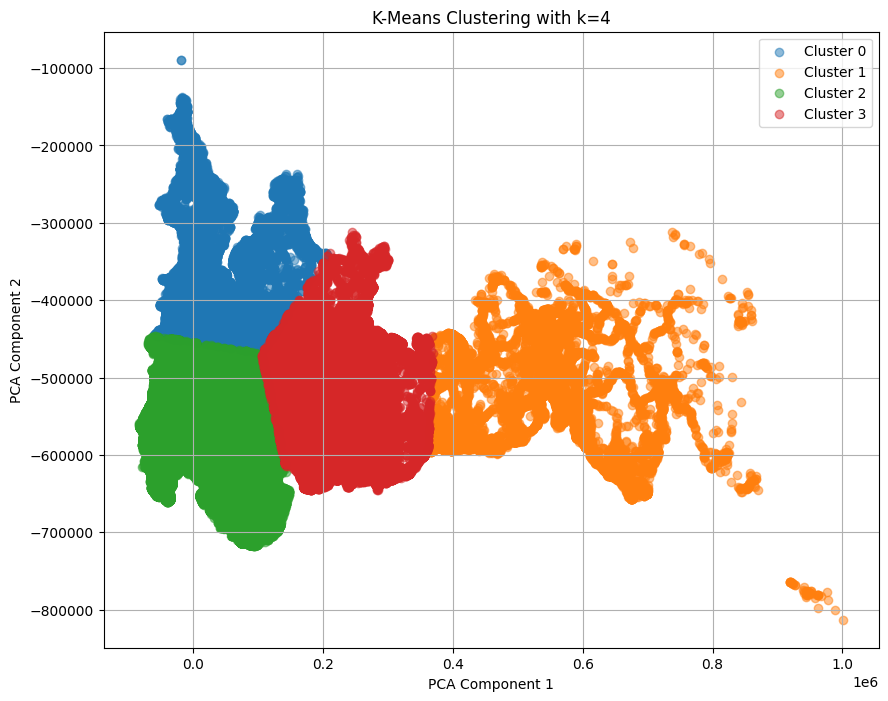

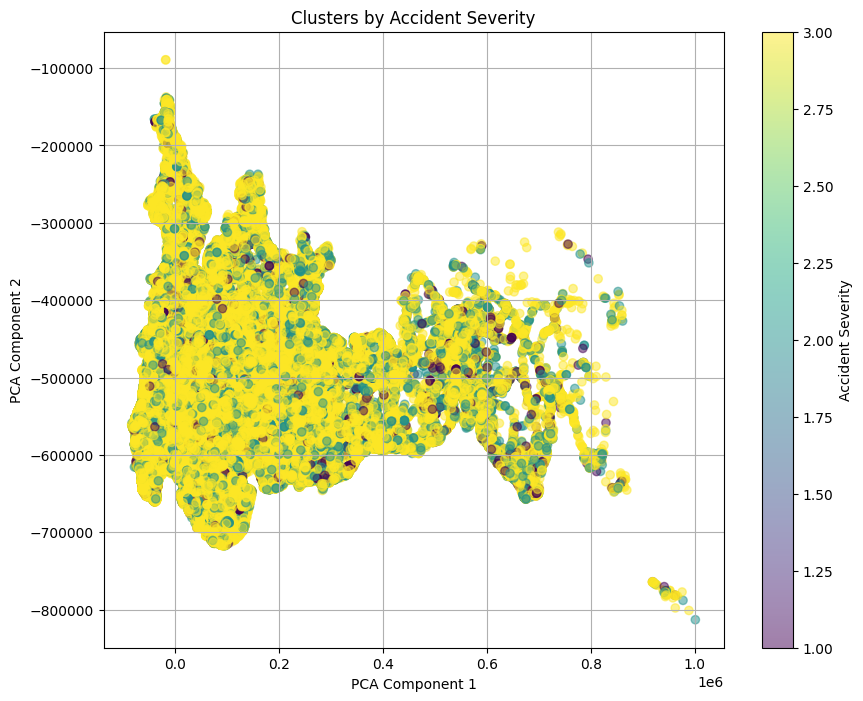

In [5]:
from pyspark.ml.feature import PCA

# Apply PCA to reduce dimensions for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(clustered_data)
result = pca_model.transform(clustered_data)

# Convert to pandas for easier plotting
pandas_df = result.select("pca_features", "prediction", "Accident_Severity").toPandas()

# Extract the PCA components
pandas_df["pca1"] = pandas_df["pca_features"].apply(lambda x: float(x[0]))
pandas_df["pca2"] = pandas_df["pca_features"].apply(lambda x: float(x[1]))

# Plot the clusters
plt.figure(figsize=(10, 8))
for cluster in range(optimal_k):
    cluster_data = pandas_df[pandas_df["prediction"] == cluster]
    plt.scatter(cluster_data["pca1"], cluster_data["pca2"], label=f"Cluster {cluster}", alpha=0.5)

plt.title(f"K-Means Clustering with k={optimal_k}")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

# Plot clusters colored by severity
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pandas_df["pca1"], pandas_df["pca2"], c=pandas_df["Accident_Severity"], cmap="viridis", alpha=0.5)
plt.colorbar(scatter, label="Accident Severity")
plt.title("Clusters by Accident Severity")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

### Geografická analýza clusterov

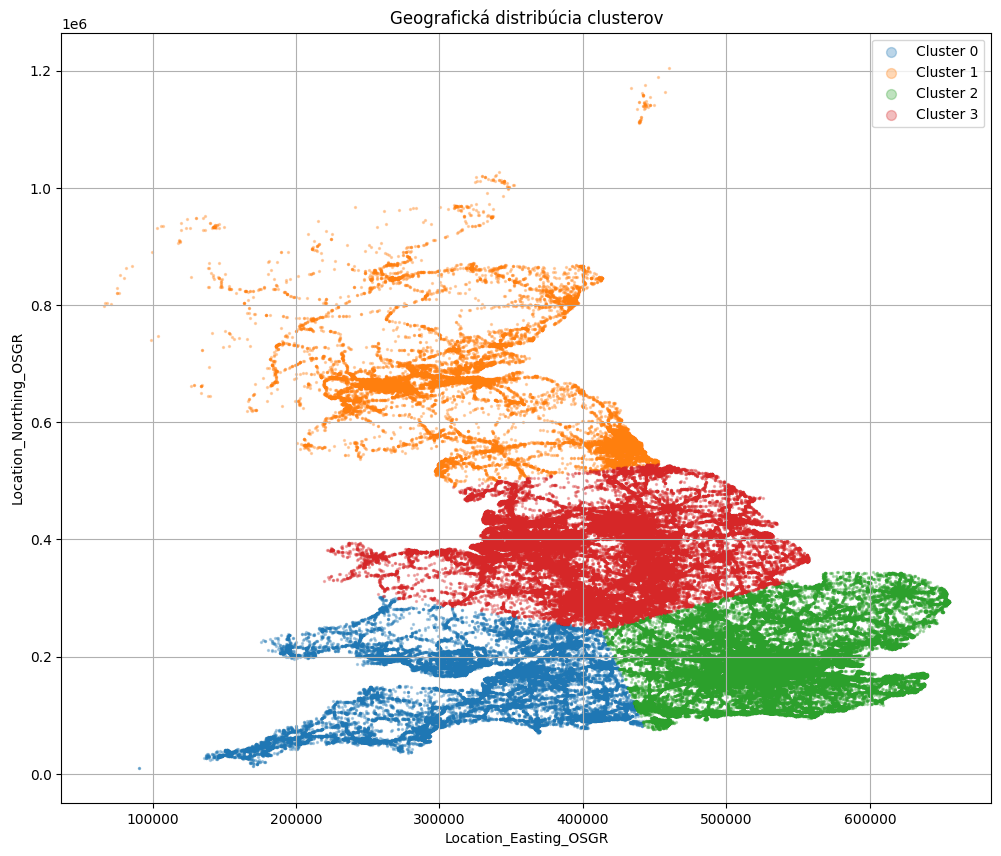

In [6]:
# Convert to pandas for visualization
geo_cluster_data = clustered_data.select("Location_Easting_OSGR", "Location_Northing_OSGR", "prediction").toPandas()

# Plot the geographic distribution of clusters
plt.figure(figsize=(12, 10))
for i in range(optimal_k):
    cluster_data = geo_cluster_data[geo_cluster_data["prediction"] == i]
    plt.scatter(
        cluster_data["Location_Easting_OSGR"], 
        cluster_data["Location_Northing_OSGR"], 
        label=f"Cluster {i}", 
        alpha=0.3,
        s=2  # Menšia veľkosť bodov pre lepšiu prehľadnosť
    )

plt.title("Geografická distribúcia clusterov")
plt.xlabel("Location_Easting_OSGR")
plt.ylabel("Location_Northing_OSGR")
plt.legend(markerscale=5)  # Zväčšíme symboly v legende pre lepšiu viditeľnosť
plt.grid(True)
plt.show()

## Hlbšia analýza charakteristík pre každý cluster

In [7]:
# Definujme funkciu pre analýzu priemerných hodnôt numerických príznakov v každom clusteri
from pyspark.sql import functions as F

def analyze_numeric_features(df, cluster_col="prediction", features=None):
    if features is None:
        features = [
            "Speed_limit",
            "Number_of_Vehicles",
            "Number_of_Casualties",
            "Urban_or_Rural_Area",
            "Location_Easting_OSGR",
            "Location_Northing_OSGR",
            "Junction_Detail",
            "Police_Force",
            "Casualty_Type",
            "Vehicle_Manoeuvre",
            "Junction_Location"
        ]
    
    # Vytvor zoznam agregácií pre všetky požadované príznaky
    aggs = [F.avg(col).alias(f"avg_{col}") for col in features]
    aggs.append(F.count(F.lit(1)).alias("count"))
    
    # Agreguj podľa clustera
    result = df.groupBy(cluster_col).agg(*aggs).orderBy(cluster_col)
    
    return result

# Analyzuj priemerné hodnoty vybraných príznakov pre každý cluster
numeric_analysis = analyze_numeric_features(clustered_data)
print("Priemerné hodnoty vybraných príznakov pre každý cluster:")
numeric_analysis.show(truncate=False)

Priemerné hodnoty vybraných príznakov pre každý cluster:
+----------+------------------+----------------------+------------------------+-----------------------+-------------------------+--------------------------+-------------------+------------------+-----------------+---------------------+---------------------+------+
|prediction|avg_Speed_limit   |avg_Number_of_Vehicles|avg_Number_of_Casualties|avg_Urban_or_Rural_Area|avg_Location_Easting_OSGR|avg_Location_Northing_OSGR|avg_Junction_Detail|avg_Police_Force  |avg_Casualty_Type|avg_Vehicle_Manoeuvre|avg_Junction_Location|count |
+----------+------------------+----------------------+------------------------+-----------------------+-------------------------+--------------------------+-------------------+------------------+-----------------+---------------------+---------------------+------+
|0         |43.46278567016677 |2.3864268066707846    |2.2213300391187976      |1.5496705785464278     |324523.3021155034        |150795.0358760552  

### Analýza pomeru mestských a vidieckych nehôd v clusteroch

In [8]:
# Urban vs Rural ratio (1 = Urban, 2 = Rural)
urban_rural_ratio = clustered_data.groupBy("prediction").pivot("Urban_or_Rural_Area", [1, 2]).count().fillna(0)
urban_rural_ratio = urban_rural_ratio.withColumn("total", F.col("1") + F.col("2"))
urban_rural_ratio = urban_rural_ratio.withColumn("urban_percentage", F.col("1") * 100 / F.col("total"))
urban_rural_ratio = urban_rural_ratio.withColumn("rural_percentage", F.col("2") * 100 / F.col("total"))

print("Pomer mestských vs. vidieckych nehôd v clusteroch:")
urban_rural_ratio.select("prediction", "1", "2", "urban_percentage", "rural_percentage").orderBy("prediction").show()

Pomer mestských vs. vidieckych nehôd v clusteroch:
+----------+-----+-----+------------------+------------------+
|prediction|    1|    2|  urban_percentage|  rural_percentage|
+----------+-----+-----+------------------+------------------+
|         0|17500|21354| 45.04040768003294| 54.95959231996706|
|         1|14965|14118|51.456177148162155|48.543822851837845|
|         2|72771|43143| 62.78016460479321| 37.21983539520679|
|         3|73616|42955| 63.15121256573247| 36.84878743426753|
+----------+-----+-----+------------------+------------------+



### Analýza závislosti na povolených rýchlostiach

In [9]:
# Speed limit distribution in each cluster
speed_limit_dist = clustered_data.groupBy("prediction").pivot("Speed_limit", [20, 30, 40, 50, 60, 70]).count().fillna(0)
speed_limit_dist = speed_limit_dist.orderBy("prediction")
print("Distribúcia rýchlostných limitov v každom clusteri:")
speed_limit_dist.show()

Distribúcia rýchlostných limitov v každom clusteri:
+----------+---+-----+-----+----+-----+-----+
|prediction| 20|   30|   40|  50|   60|   70|
+----------+---+-----+-----+----+-----+-----+
|         0|329|19104| 3606|1840|10554| 3423|
|         1|295|14886| 1888|1047| 8437| 2530|
|         2|842|69659|10361|4975|16011|14063|
|         3|917|70667|11719|3957|18193|11138|
+----------+---+-----+-----+----+-----+-----+



### Analýza križovatiek

In [11]:
# Analýza typu križovatiek v jednotlivých clusteroch (Junction_Detail)
junction_analysis = clustered_data.groupBy("prediction").pivot("Junction_Detail").count().fillna(0)

# Pre lepšiu interpretáciu zobrazíme percentuálny podiel typu križovatiek v každom clusteri
junction_cols = [col for col in junction_analysis.columns if col != "prediction"]

# Najprv vypočítame celkový súčet pre každý row (cluster)
junction_analysis = junction_analysis.withColumn("total", sum([F.col(col) for col in junction_cols]))

# Potom vypočítame percentuálny podiel každého typu križovatky
for col in junction_cols:
    junction_analysis = junction_analysis.withColumn(f"pct_{col}", F.col(col) * 100 / F.col("total"))

print("Distribúcia typov križovatiek v clusteroch (percentuálny podiel):")
junction_analysis.select("prediction", *[f"pct_{col}" for col in junction_cols]).show(truncate=False)

Distribúcia typov križovatiek v clusteroch (percentuálny podiel):
+----------+---------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|prediction|pct_-1               |pct_0            |pct_1            |pct_2             |pct_3             |pct_5             |pct_6             |pct_7             |pct_8             |pct_9             |
+----------+---------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|1         |0.013753739297871609 |45.88935116734862|9.11185228483994 |0.6567410514733694|26.469071278753912|2.3003128975690266|7.977168792765533 |1.0280920125159028|2.3759584637073203|4.177698311728501 |
|3         |0.0017153982725939395|37.86312837182973|7.869389575524697|0.8525529414791879|30.6258630597559  |1.53013525